## ERA5 data on the Planetary Computer

The [ERA5 dataset](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) from the ECMWF, converted to Zarr by [PlanetOS](https://planetos.com/) data on weather.

### Query using the STAC API

The data assets are a collection of Zarr groups, which can be opened with libraries like [xarray](https://xarray.pydata.org/).

Each STAC item covers a single month and the entire globe. You'll likely query on the `datetime`.

In [1]:
import pystac_client

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/"
)
search = catalog.search(collections=["era5-pds"], datetime="1980-01")
items = search.get_all_items()

len(items)

2

In [2]:
list(items)

[<Item id=era5-pds-1980-01-fc>, <Item id=era5-pds-1980-01-an>]

There will be two items per month, depending on the kind of variables within: `fc` (or "forecast") and `an` (or "analysis").

* An **analysis**, of the atmospheric conditions, is a blend of observations
  with a previous forecast. An analysis can only provide
  [instantaneous](https://confluence.ecmwf.int/display/CKB/Model+grid+box+and+time+step)
  parameters (parameters valid at a specific time, e.g temperature at 12:00),
  but not accumulated parameters, mean rates or min/max parameters.
* A **forecast** starts with an analysis at a specific time (the 'initialization
  time'), and a model computes the atmospheric conditions for a number of
  'forecast steps', at increasing 'validity times', into the future. A forecast
  can provide
  [instantaneous](https://confluence.ecmwf.int/display/CKB/Model+grid+box+and+time+step)
  parameters, accumulated parameters, mean rates, and min/max parameters.

You can narrow your search to a specific kind using the `era5:kind` property.

In [3]:
import pystac_client

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/"
)
search = catalog.search(
    collections=["era5-pds"], datetime="1980-01", query={"era5:kind": {"eq": "an"}}
)
items = search.get_all_items()

print(len(items))
item = items[0]

1


There are several assets avaiable, one for each data variable. We can build up a dataset with all the variables using `xarray.open_dataset` and `combine_by_coords`.

In [4]:
import planetary_computer
import xarray as xr

signed_item = planetary_computer.sign(item)
datasets = [
    xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
    for asset in signed_item.assets.values()
]

ds = xr.combine_by_coords(datasets, join="exact")
ds

<xarray.Dataset>
Dimensions:                            (time: 744, lat: 721, lon: 1440)
Coordinates:
  * lat                                (lat) float32 90.0 89.75 ... -89.75 -90.0
  * lon                                (lon) float32 0.0 0.25 ... 359.5 359.8
  * time                               (time) datetime64[ns] 1980-01-01 ... 1...
Data variables:
    air_pressure_at_mean_sea_level     (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    air_temperature_at_2_metres        (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    dew_point_temperature_at_2_metres  (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    eastward_wind_at_100_metres        (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    eastward_wind_at_10_metres         (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    northward_wind_at_100_metres       (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    northward_wind_at_10_metres        (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    sea_surface_temperature            (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    surface_air_pressure               (time, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

Now we can plot timeseries for the month, averaged over space:

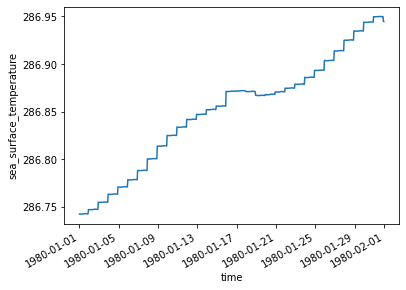

In [5]:
ds["sea_surface_temperature"].mean(dim=["lon", "lat"]).plot();

Or make a map of some variable on a single date.

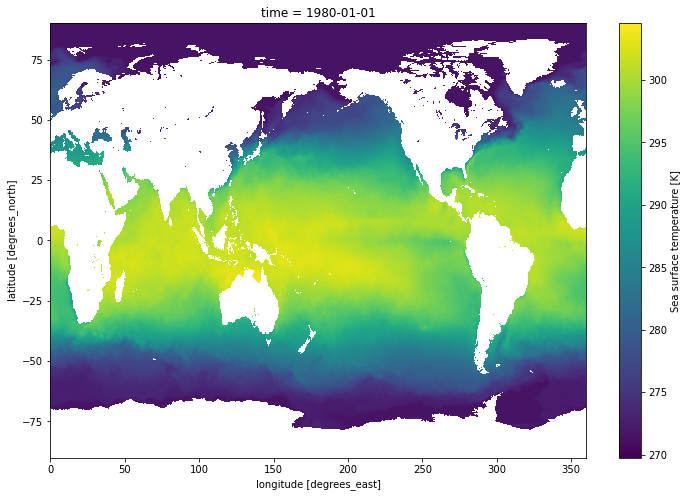

In [6]:
ds["sea_surface_temperature"].isel(time=0).plot(size=8);